# Figure B1: Contrail width evolution of all contrails

Note: before running this script, you need to run [figure_7.ipynb](figure_7.ipynb) to process the contrail labels into width evolution series (for which you need the full dataset downloaded). 

In [5]:
import os
import json

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset

In [6]:
input_dir = "../../data/contrail_evolution/annotations"

contrails = {}

for filename in os.listdir(input_dir):
    if filename.endswith(".json"):
        scene_id = filename.replace(".json", "")
        
        with open(os.path.join(input_dir, filename)) as f:
            data = json.load(f)

        # Convert lists back to numpy arrays where needed
        for key in ["x", "y", "distance", "width", "age"]:
            if key in data:
                data[key] = np.array(data[key])

        contrails[scene_id] = data

In [7]:
all_data = []

for d in contrails.values():
    icao_code = d["icao_code"]
    
    # Extract arrays
    age = d["age"]
    width = d["width"]

    df_tmp = pd.DataFrame({
        "age": pd.to_numeric(age, errors="coerce"),
        "width": pd.to_numeric(width, errors="coerce"),
    })
    # 1. Drop NaNs
    df_tmp = df_tmp.dropna(subset=["width"])

    # If nothing left, skip
    if df_tmp.empty:
        continue

    df_tmp["age"] = df_tmp["age"].astype(int)
    df_tmp["width"] = df_tmp["width"].astype(float)

    # 2. Group by age (in case of duplicates) and take mean
    df_tmp = df_tmp.groupby("age", as_index=False).mean()

    # 3. Create full 1-second age grid
    age_full = np.arange(1, df_tmp["age"].max() + 1)

    # 4. Reindex and interpolate
    df_tmp = (
        df_tmp
        .set_index("age")
        .reindex(age_full)
        .interpolate(method="linear")
        .reset_index()
        .rename(columns={"index": "age"})
    )
    df_tmp["icao_code"] = icao_code  # keep icao_code for plotting
    df_tmp["scene_id"] = d["scene_id"]
    all_data.append(df_tmp)

# 5. Combine all contrails
df_all = pd.concat(all_data, ignore_index=True)
df_all = df_all.dropna(subset=["width"])
# Map ICAO to categories
def map_category(code):
    if code.startswith("A33"):
        return "A330"
    elif code.startswith("A34"):
        return "A340"
    else:
        return "Other"

df_all["category"] = df_all["icao_code"].apply(map_category)

/var/folders/zt/t69lkpcs0mz7l5vz3jt_48ldzb8s6f/T/ipykernel_20785/1813960366.py:88: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


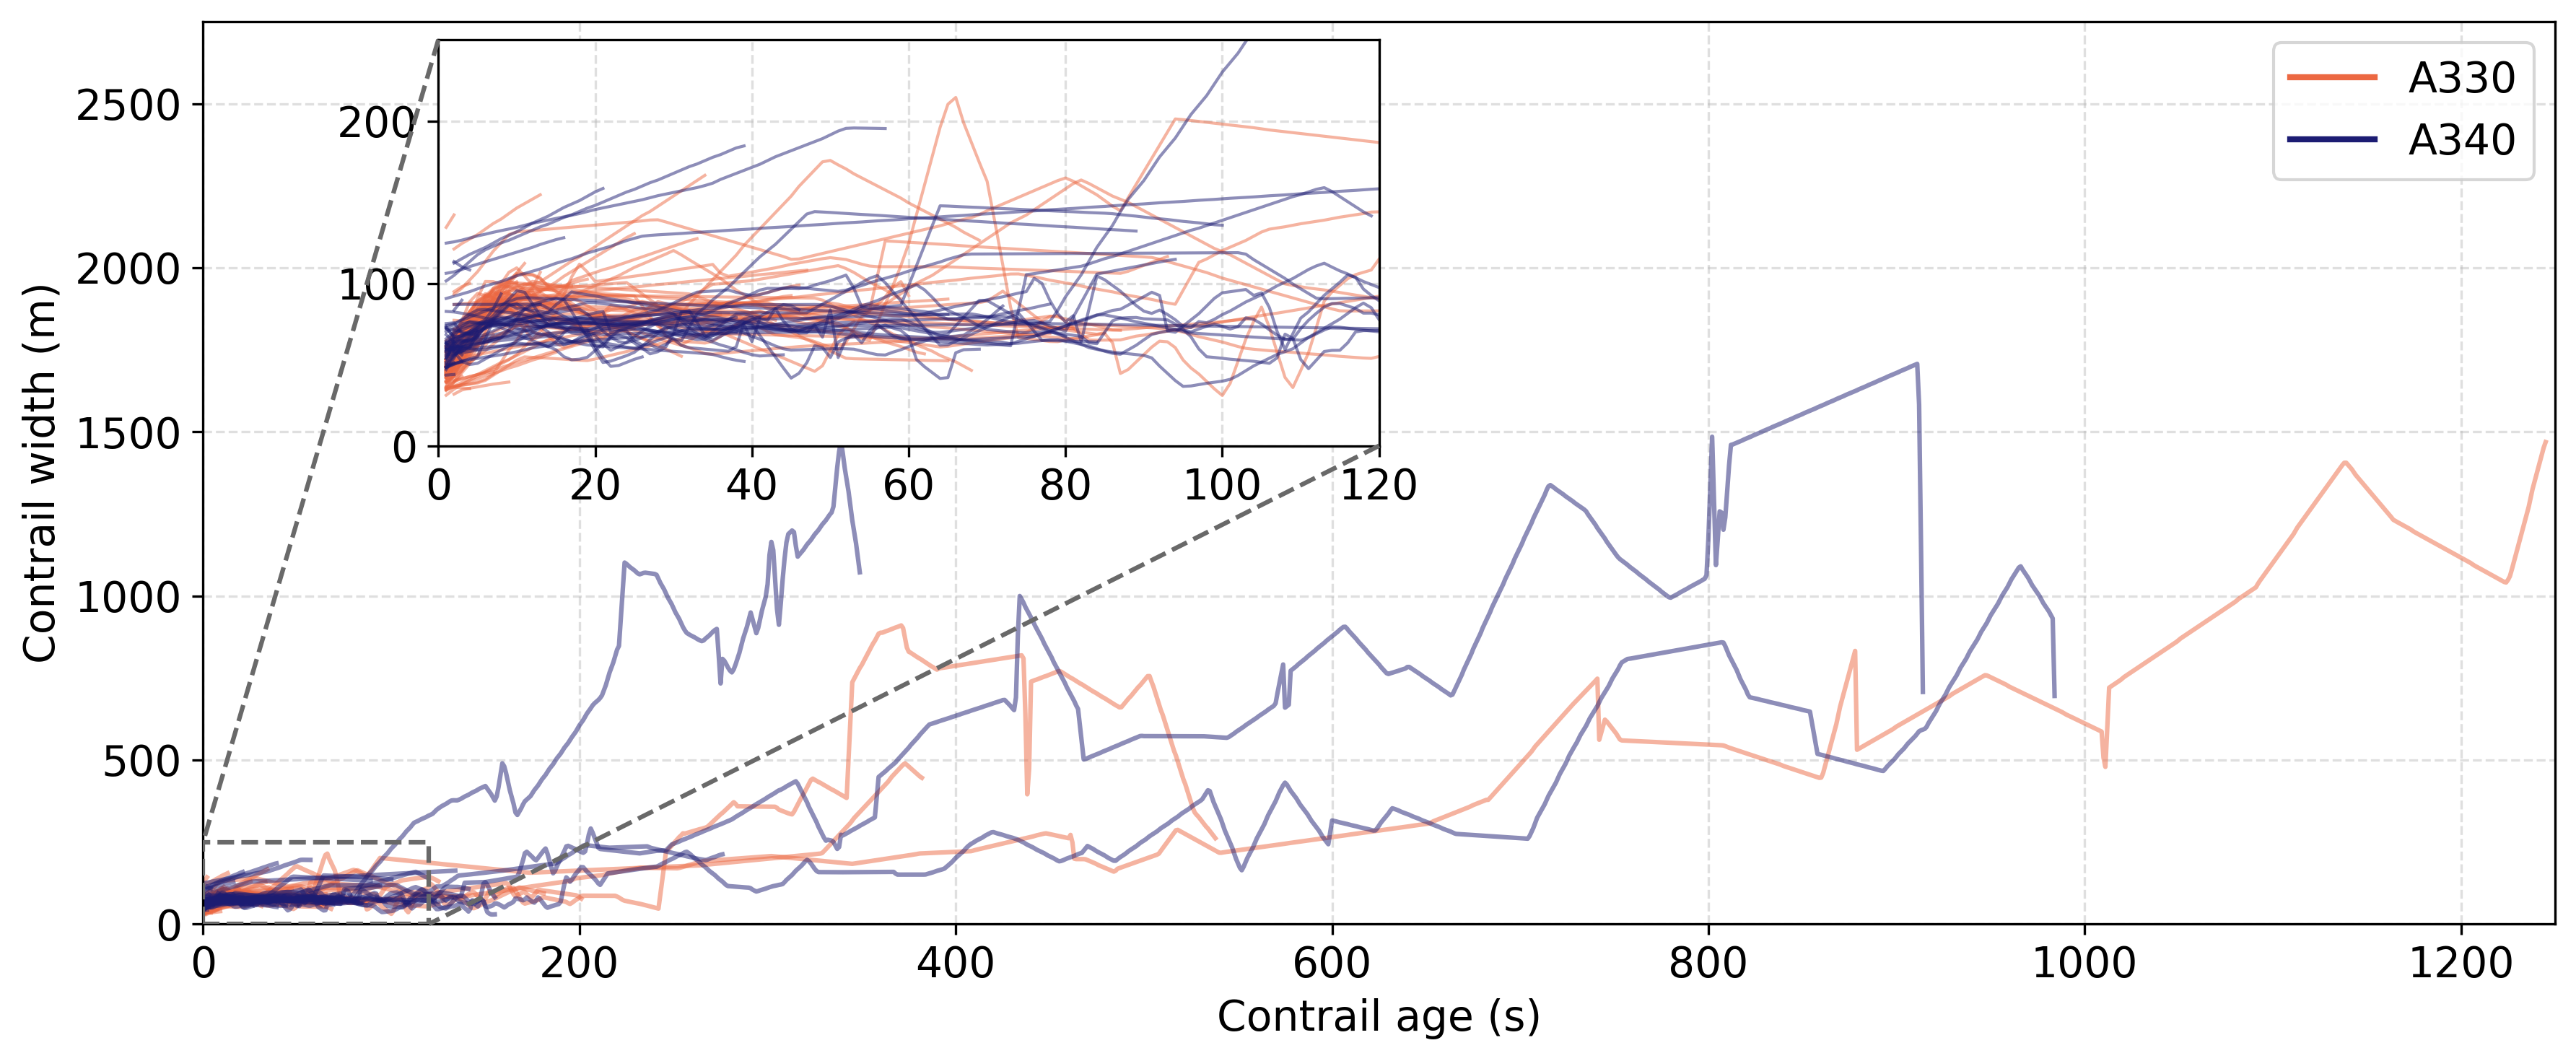

In [8]:


plt.rcParams.update({
    "axes.titlesize": 14,
    "axes.labelsize": 14,
    "xtick.labelsize": 14,
    "ytick.labelsize": 14,
    "legend.fontsize": 14
})


# Aircraft colours
colors = {
    "A330": "#ec6842",
    "A340": "#1c1c73"
}

markers = {
    "A330": "-",
    "A340": "dotted"
}

# Create main figure
fig, ax = plt.subplots(figsize=(12, 5), dpi=300)

# Plot individual contrails
for cat in ["A330", "A340"]:
    df_cat = df_all[df_all["category"] == cat]

    for scene_id, df_scene in df_cat.groupby("scene_id"):
        ax.plot(
            df_scene["age"],
            df_scene["width"],
            color=colors[cat],
            alpha=0.5,
            linewidth=1.5
        )

# Main axis formatting
ax.set_xlim(0, 1250)
ax.set_ylim(0, 2750)
ax.set_xlabel("Contrail age (s)")
ax.set_ylabel("Contrail width (m)")
ax.grid(True, linestyle="--", alpha=0.4)

# Legend
for cat in ["A330", "A340"]:
    ax.plot([], [], color=colors[cat], label=cat, linewidth=2)

ax.legend(frameon=True, loc="upper right")

# Inset: early-time zoom
ax_inset = inset_axes(
    ax,
    width="40%",
    height="45%",
    bbox_to_anchor=(-0.5, -0.02, 1, 1),  # (x0, y0, _, _) in axes fraction
    bbox_transform=ax.transAxes,
    borderpad=0
)

for cat in ["A330", "A340"]:
    df_cat = df_all[df_all["category"] == cat]

    for scene_id, df_scene in df_cat.groupby("scene_id"):
        ax_inset.plot(
            df_scene["age"],
            df_scene["width"],
            color=colors[cat],
            alpha=0.5,
            linewidth=1
        )

ax_inset.set_xlim(0, 120)
ax_inset.set_ylim(0, 250)
ax_inset.grid(True, linestyle="--", alpha=0.4)

mark_inset(
    ax,
    ax_inset,
    loc1=2,
    loc2=4,
    fc="none",
    ec="dimgrey",
    linestyle="--",
    lw=1.5,
    zorder=17
)

plt.tight_layout()
plt.savefig("figures/figB1.png", dpi=300, bbox_inches='tight', pad_inches=0.1)
plt.show()